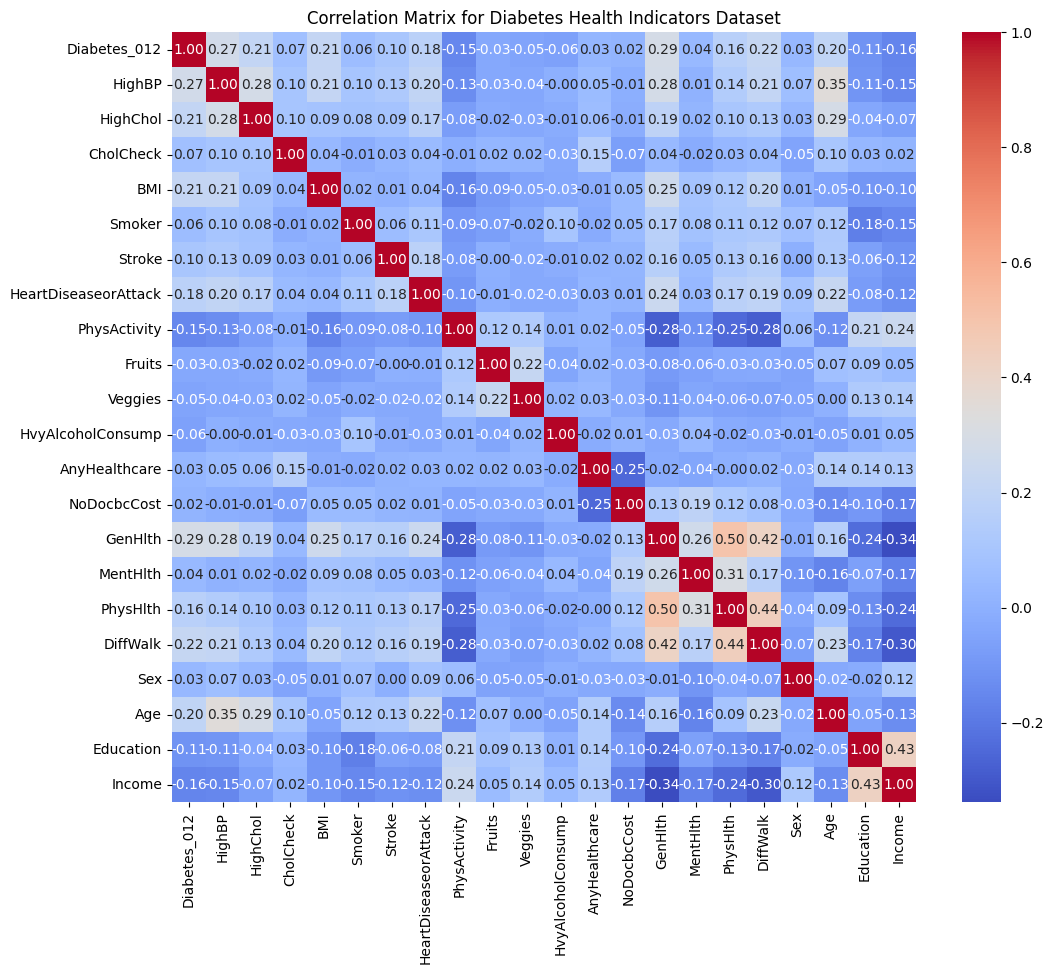

                      Diabetes_012    HighBP  HighChol  CholCheck       BMI  \
Diabetes_012              1.000000  0.269086  0.207435   0.072222  0.211801   
HighBP                    0.269086  1.000000  0.283285   0.099415  0.213951   
HighChol                  0.207435  0.283285  1.000000   0.098558  0.087188   
CholCheck                 0.072222  0.099415  0.098558   1.000000  0.036226   
BMI                       0.211801  0.213951  0.087188   0.036226  1.000000   
Smoker                    0.058910  0.099570  0.082402  -0.012874  0.016289   
Stroke                    0.102715  0.126594  0.085947   0.025386  0.010241   
HeartDiseaseorAttack      0.177432  0.203191  0.170668   0.043867  0.039518   
PhysActivity             -0.151657 -0.132253 -0.076648  -0.008454 -0.163979   
Fruits                   -0.030489 -0.031542 -0.024408   0.024951 -0.089897   
Veggies                  -0.047853 -0.036013 -0.031931   0.017397 -0.047900   
HvyAlcoholConsump        -0.058904 -0.003424 -0.0142

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2021.csv')

# Calculate the correlation matrix for the new dataset
correlation_matrix_new = data.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_new, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Diabetes Health Indicators Dataset')
plt.show()

# Display the correlation matrix itself
print(correlation_matrix_new)

Define Deep Learning Model

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN  # Import SMOTE for oversampling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Load the dataset
data = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2015.csv')

# Selecting features and target
X = data.drop(columns=['Diabetes_012'])  # All columns except the target
y = data['Diabetes_012']  # Target column for prediction

# Identify continuous and binary features
continuous_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                   'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                   'NoDocbcCost', 'DiffWalk', 'Sex']

# Scale only continuous features
scaler = StandardScaler()
X[continuous_features] = scaler.fit_transform(X[continuous_features])

y = to_categorical(y)

# Split the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Use SMOTEENN to perform a combination of over-sampling the minority class and under-sampling the majority class
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)




# Function to build a neural network model
def build_model(input_dim, units_1, units_2, dropout_rate):
    model = Sequential()

    # First Dense Layer with Batch Normalization and LeakyReLU
    model.add(Dense(units=units_1, input_dim=input_dim, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(dropout_rate))

    # Second Dense Layer with Batch Normalization and LeakyReLU
    model.add(Dense(units=units_2, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(dropout_rate))

    # Third Dense Layer with Batch Normalization and LeakyReLU
    model.add(Dense(units=32, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # Output layer for multi-class classification
    model.add(Dense(units=3, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Variables to store the best accuracy and the best model filename
best_accuracy = 0
best_model_filename = 'best_model.h5'

# Learning Rate Scheduler
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Hyperparameter grid search
units_1_options = [64, 128]
units_2_options = [32, 64]
dropout_rates = [0.2, 0.3]
epochs = 100
batch_size = 32

for units_1 in units_1_options:
    for units_2 in units_2_options:
        for dropout_rate in dropout_rates:
            # Build and train the model
            model = build_model(input_dim=X_train.shape[1], units_1=units_1, units_2=units_2, dropout_rate=dropout_rate)
            model.fit(X_resampled, y_resampled, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                      callbacks=[lr_schedule], verbose=1)

            # Evaluate the model on the test set
            y_pred = model.predict(X_test)
            y_pred_class = np.argmax(y_pred, axis=1)
            y_test_class = np.argmax(y_test, axis=1)

            # Calculate accuracy
            accuracy = accuracy_score(y_test_class, y_pred_class)
            print(f"Model with {units_1} and {units_2} units, dropout {dropout_rate}: Accuracy = {accuracy}")

            # If the new accuracy is better, save the model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_filename = f"best_model_units1_{units_1}_units2_{units_2}_dropout_{dropout_rate}.h5"
                model.save(f'/content/all_features_batchnormal_lr_scheduler/{best_model_filename}')
                print(f"New best model saved as {best_model_filename} with accuracy: {accuracy}")

print(f"Best model saved as {best_model_filename} with accuracy: {best_accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.6252 - loss: 0.8108 - val_accuracy: 0.1291 - val_loss: 1.2977 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6550 - loss: 0.7592 - val_accuracy: 0.1054 - val_loss: 1.2875 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6650 - loss: 0.7446 - val_accuracy: 0.1004 - val_loss: 1.3564 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6682 - loss: 0.7373 - val_accuracy: 0.1387 - val_loss: 1.2828 - learning_rate: 0.0010
Epoch 5/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6721 - loss: 0.7315 - val_accuracy: 0.1523 - val_loss: 1.3233 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6759 - loss: 0.7273 - val_accuracy: 0.1569 - val_loss: 1.3168 - learning_rate: 0.0010
Epoch 7/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms

Model with 64 and 32 units, dropout 0.2: Accuracy = 0.5066422264269946
New best model saved as best_model_units1_64_units2_32_dropout_0.2.h5 with accuracy: 0.5066422264269946


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.6167 - loss: 0.8293 - val_accuracy: 0.1188 - val_loss: 1.2293 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6491 - loss: 0.7676 - val_accuracy: 0.1217 - val_loss: 1.2194 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6529 - loss: 0.7599 - val_accuracy: 0.1291 - val_loss: 1.2650 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6604 - loss: 0.7490 - val_accuracy: 0.0982 - val_loss: 1.3180 - learning_rate: 0.0010
Epoch 5/100
10674/10693 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 0.7464
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6621 - loss: 0.7464 - val_accuracy: 0.1386 - val_loss: 1.2830 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.6299 - loss: 0.8014 - val_accuracy: 0.1494 - val_loss: 1.2569 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6582 - loss: 0.7522 - val_accuracy: 0.1513 - val_loss: 1.2532 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6686 - loss: 0.7353 - val_accuracy: 0.1924 - val_loss: 1.2787 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6728 - loss: 0.7298 - val_accuracy: 0.1452 - val_loss: 1.3277 - learning_rate: 0.0010
Epoch 5/100
10675/10693 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6758 - loss: 0.7233
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6758 - loss: 0.7233 - val_accuracy: 0.1703 - val_loss: 1.2739 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/st

Model with 64 and 64 units, dropout 0.2: Accuracy = 0.5224101229895932
New best model saved as best_model_units1_64_units2_64_dropout_0.2.h5 with accuracy: 0.5224101229895932


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6253 - loss: 0.8095 - val_accuracy: 0.0971 - val_loss: 1.2780 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6520 - loss: 0.7630 - val_accuracy: 0.1079 - val_loss: 1.3158 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6583 - loss: 0.7524 - val_accuracy: 0.1134 - val_loss: 1.3397 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6610 - loss: 0.7477 - val_accuracy: 0.1773 - val_loss: 1.2473 - learning_rate: 0.0010
Epoch 5/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6651 - loss: 0.7421 - val_accuracy: 0.1706 - val_loss: 1.2810 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6674 - loss: 0.7379 - val_accuracy: 0.0931 - val_loss: 1.3698 - learning_rate: 0.0010
Epoch 7/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.6341 - loss: 0.7947 - val_accuracy: 0.0674 - val_loss: 1.3565 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6648 - loss: 0.7438 - val_accuracy: 0.2474 - val_loss: 1.1804 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6719 - loss: 0.7309 - val_accuracy: 0.2023 - val_loss: 1.2250 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6800 - loss: 0.7192 - val_accuracy: 0.2672 - val_loss: 1.1866 - learning_rate: 0.0010
Epoch 5/100
10685/10693 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 0.7086
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6855 - loss: 0.7086 - val_accuracy: 0.1979 - val_loss: 1.2622 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/st

Model with 128 and 32 units, dropout 0.2: Accuracy = 0.5500039419741406
New best model saved as best_model_units1_128_units2_32_dropout_0.2.h5 with accuracy: 0.5500039419741406


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6294 - loss: 0.8068 - val_accuracy: 0.0747 - val_loss: 1.3515 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6529 - loss: 0.7624 - val_accuracy: 0.1188 - val_loss: 1.2994 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6645 - loss: 0.7446 - val_accuracy: 0.2103 - val_loss: 1.1836 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6684 - loss: 0.7369 - val_accuracy: 0.2374 - val_loss: 1.1636 - learning_rate: 0.0010
Epoch 5/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6735 - loss: 0.7287 - val_accuracy: 0.2084 - val_loss: 1.2284 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6764 - loss: 0.7233 - val_accuracy: 0.1828 - val_loss: 1.2513 - learning_rate: 0.0010
Epoch 7/100
10675/10693 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.6359 - loss: 0.7904 - val_accuracy: 0.1033 - val_loss: 1.3343 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6674 - loss: 0.7384 - val_accuracy: 0.2033 - val_loss: 1.2539 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6826 - loss: 0.7161 - val_accuracy: 0.3113 - val_loss: 1.1815 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6884 - loss: 0.7047 - val_accuracy: 0.2479 - val_loss: 1.2557 - learning_rate: 0.0010
Epoch 5/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6945 - loss: 0.6969 - val_accuracy: 0.3101 - val_loss: 1.1513 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6983 - loss: 0.6902 - val_accuracy: 0.3130 - val_loss: 1.1730 - learning_rate: 0.0010
Epoch 7/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms

Model with 128 and 64 units, dropout 0.2: Accuracy = 0.5951592557552823
New best model saved as best_model_units1_128_units2_64_dropout_0.2.h5 with accuracy: 0.5951592557552823


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6288 - loss: 0.8029 - val_accuracy: 0.0772 - val_loss: 1.3513 - learning_rate: 0.0010
Epoch 2/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6581 - loss: 0.7516 - val_accuracy: 0.1279 - val_loss: 1.3276 - learning_rate: 0.0010
Epoch 3/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6694 - loss: 0.7359 - val_accuracy: 0.1609 - val_loss: 1.2818 - learning_rate: 0.0010
Epoch 4/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6758 - loss: 0.7259 - val_accuracy: 0.2294 - val_loss: 1.2381 - learning_rate: 0.0010
Epoch 5/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6784 - loss: 0.7203 - val_accuracy: 0.1646 - val_loss: 1.2943 - learning_rate: 0.0010
Epoch 6/100
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6841 - loss: 0.7125 - val_accuracy: 0.1813 - val_loss: 1.2900 - learning_rate: 0.0010
Epoch 7/100
10680/10693 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

Performing Transfer Learning on Best Model (Gestational Dataset)




In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the new dataset
data = pd.read_csv('/content/gestational_diabetes_dataset.csv')
# load pretrained model
pretrained_model = load_model('/content/best_model_units1_128_units2_64_dropout_0.2.h5')


# Get the input shape from the dataset (8 features)
input_shape = (8,)

# Build a new model based on the pre-trained model
model = Sequential()

# Modify the input layer to match the new dataset
model.add(Dense(128, input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.2))

# Reuse the rest of the pre-trained layers (we'll add them layer by layer)
for layer in pretrained_model.layers[1:-1]:
    model.add(layer)

# Add a new output layer with 1 neuron for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the new model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

X = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the modified model on the new dataset using transfer learning
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Save the fine-tuned model
model.save('fine_tuned_model_with_modified_input.h5')



'''
# Select features and labels
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = data[features]
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. Load the pre-trained model
model = load_model('/content/all_features_batchnormal_lr_scheduler/best_model_units1_128_units2_64_dropout_0.2.h5')

# 2. Modify the input layer dimension to match the new dataset (8 features)
new_input = layers.Input(shape=(X_train.shape[1],))  # Shape matches the 8 features of the new dataset
old_layers = model.layers[1:]  # Exclude the original input layer

# Reconnect the old layers with the new input
x = new_input
for layer in old_layers:
    x = layer(x)

# Build the new model
new_model = Model(inputs=new_input, outputs=x)

# 3. Freeze all layers except the last one
for layer in new_model.layers[:-1]:  # Freeze all layers except the last one
    layer.trainable = False

# 4. Modify the last layer for binary classification
new_model.layers[-1] = layers.Dense(1, activation='sigmoid')  # Adjust this for binary classification

# 5. Compile the model
new_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the modified model on the new dataset
history = new_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[lr_schedule], verbose=1)

# Save the updated model
new_model.save('/content/gestational_health_indicator_model/model.h5')
'''









Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.4721 - loss: 0.8294 - val_accuracy: 0.3571 - val_loss: 0.9633
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6125 - loss: 0.6923 - val_accuracy: 0.6299 - val_loss: 0.6734
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6657 - loss: 0.6309 - val_accuracy: 0.6494 - val_loss: 0.6351
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7144 - loss: 0.5870 - val_accuracy: 0.6494 - val_loss: 0.6512
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7644 - loss: 0.5359 - val_accuracy: 0.6494 - val_loss: 0.6805
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7248 - loss: 0.5767 - val_accuracy: 0.6494 - val_loss: 0.6853
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7270 - loss: 0.5513 - val_accuracy: 0.6494 - val_loss: 0.6818
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7526 - loss: 0.5188 - val_accuracy: 0.6494 - val_loss: 0.6731


"\n# Select features and labels\nfeatures = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']\nX = data[features]\ny = data['Outcome']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Scale the features\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n# 1. Load the pre-trained model\nmodel = load_model('/content/all_features_batchnormal_lr_scheduler/best_model_units1_128_units2_64_dropout_0.2.h5')\n\n# 2. Modify the input layer dimension to match the new dataset (8 features)\nnew_input = layers.Input(shape=(X_train.shape[1],))  # Shape matches the 8 features of the new dataset\nold_layers = model.layers[1:]  # Exclude the original input layer\n\n# Reconnect the old layers with the new input\nx = new_input\nfor layer in old_layers:\n    x = layer(x)\n\n# Build the new mod

Test Predictions on Fine Tuned Model

In [ ]:
import numpy as np

# Load the fine-tuned model
fine_tuned_model = load_model('fine_tuned_model_with_modified_input.h5')

# Perform predictions on the test data
y_pred = fine_tuned_model.predict(X_test_scaled)

# Convert probabilities to binary outcome (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Display the first few predictions and their corresponding true values
predictions_comparison = pd.DataFrame({'True Outcome': y_test, 'Predicted Outcome': y_pred_binary.flatten()})
print(predictions_comparison.head())

# Evaluate the model on the test data
test_loss, test_accuracy = fine_tuned_model.evaluate(X_test_scaled, y_test)

# Print out the test accuracy and loss
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
     True Outcome  Predicted Outcome
668             0                  0
324             0                  0
624             0                  0
690             0                  0
473             0                  0
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7324 - loss: 0.5545
Test Accuracy: 73.38%
Test Loss: 0.5645


Using new dataset with more features: https://github.com/steve-zeyu-zhang/DiabetesDiagnosis/blob/main/data/BIT_2019.csv

In [2]:
import pandas as pd

# Load the dataset
file_path = 'BIT_2019.csv'
data = pd.read_csv(file_path)

# Function to classify diabetes status based on Diabetic, Pdiabetes, and Pregancies columns
def classify_diabetes(row):
    if row['Diabetic'] == 'no' and row['Pdiabetes'] == 0:
        return 'No Diabetes'
    elif row['Pdiabetes'] == 1:
        return 'Prediabetes'
    elif row['Diabetic'] == 'yes' and row['Pregancies'] == 0:
        return 'Type-2 Diabetes'
    elif row['Diabetic'] == 'yes' and row['Pregancies'] > 0:
        return 'Gestational Diabetes'
    else:
        return 'Unknown'

# Fill missing values in 'Pdiabetes' and 'Diabetic' columns
data['Pdiabetes'].fillna('0', inplace=True)  # Assuming no prediabetes for missing values
data['Diabetic'].fillna('no', inplace=True)  # Assuming no diabetes for missing values

# Standardize the 'Pdiabetes' column to binary format (0 for no, 1 for yes)
data['Pdiabetes'] = data['Pdiabetes'].replace({'yes': 1, 'no': 0, '0': 0}).astype(int)

# Apply the classification function to create the target column 'Diabetes_Status'
data['Diabetes_Status'] = data.apply(classify_diabetes, axis=1)

# Check the distribution of the newly created 'Diabetes_Status' column
print(data['Diabetes_Status'].value_counts())

# Drop rows where 'Diabetes_Status' is 'Unknown'
data_cleaned = data[data['Diabetes_Status'] != 'Unknown']

# Check the updated distribution after dropping 'Unknown' cases
print(data_cleaned['Diabetes_Status'].value_counts())

print(data.head())

Diabetes_Status
No Diabetes             684
Type-2 Diabetes         188
Gestational Diabetes     64
Prediabetes              14
Unknown                   2
Name: count, dtype: int64
Diabetes_Status
No Diabetes             684
Type-2 Diabetes         188
Gestational Diabetes     64
Prediabetes              14
Name: count, dtype: int64
     Age Gender Family_Diabetes highBP      PhysicallyActive   BMI Smoking  \
0  50-59   Male              no    yes        one hr or more  39.0      no   
1  50-59   Male              no    yes  less than half an hr  28.0      no   
2  40-49   Male              no     no        one hr or more  24.0      no   
3  50-59   Male              no     no        one hr or more  23.0      no   
4  40-49   Male              no     no  less than half an hr  27.0      no   

  Alcohol  Sleep  SoundSleep RegularMedicine      JunkFood     Stress BPLevel  \
0      no      8           6              no  occasionally  sometimes    high   
1      no      8           6     

C:\Users\ashna\AppData\Local\Temp\ipykernel_47060\2256321804.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Pdiabetes'].fillna('0', inplace=True)  # Assuming no prediabetes for missing values
C:\Users\ashna\AppData\Local\Temp\ipykernel_47060\2256321804.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import joblib

# Drop the 'Diabetic' column as it's redundant
X = data_cleaned.drop(['Diabetic', 'Diabetes_Status'], axis=1)
y = data_cleaned['Diabetes_Status']

# Define a function to convert age ranges to numeric values (e.g., using the midpoint of the range)
def convert_age_range(age_range):
    if isinstance(age_range, str) and '-' in age_range:
        age_min, age_max = age_range.split('-')
        return (int(age_min) + int(age_max)) // 2
    else:
        return pd.to_numeric(age_range, errors='coerce')  # Handle any non-range values

# Apply the function to the Age column
X['Age'] = X['Age'].apply(convert_age_range)

# Split the data into training and testing sets before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode categorical columns and scale numerical columns
categorical_features = ['Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'Smoking', 'Alcohol', 'BPLevel']
numerical_features = ['Age', 'BMI', 'Pregancies', 'Sleep', 'SoundSleep']

# Create a preprocessor that scales numerical data and one-hot encodes categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fit the preprocessor on the training data and transform both the training and test data and saving it for training data from Streamlit app
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

joblib.dump(preprocessor, 'preprocesser.pkl')

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_processed)

# Encode the target variable (y_train) using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Check class distribution before applying SMOTE
print("Class distribution before SMOTE:", Counter(y_train_encoded))

# Apply SMOTE to the imputed training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train_encoded)

# Check class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_train_smote))


Class distribution before SMOTE: Counter({1: 548, 3: 150, 0: 53, 2: 9})
Class distribution after SMOTE: Counter({3: 548, 1: 548, 0: 548, 2: 548})


Correlation Matrix

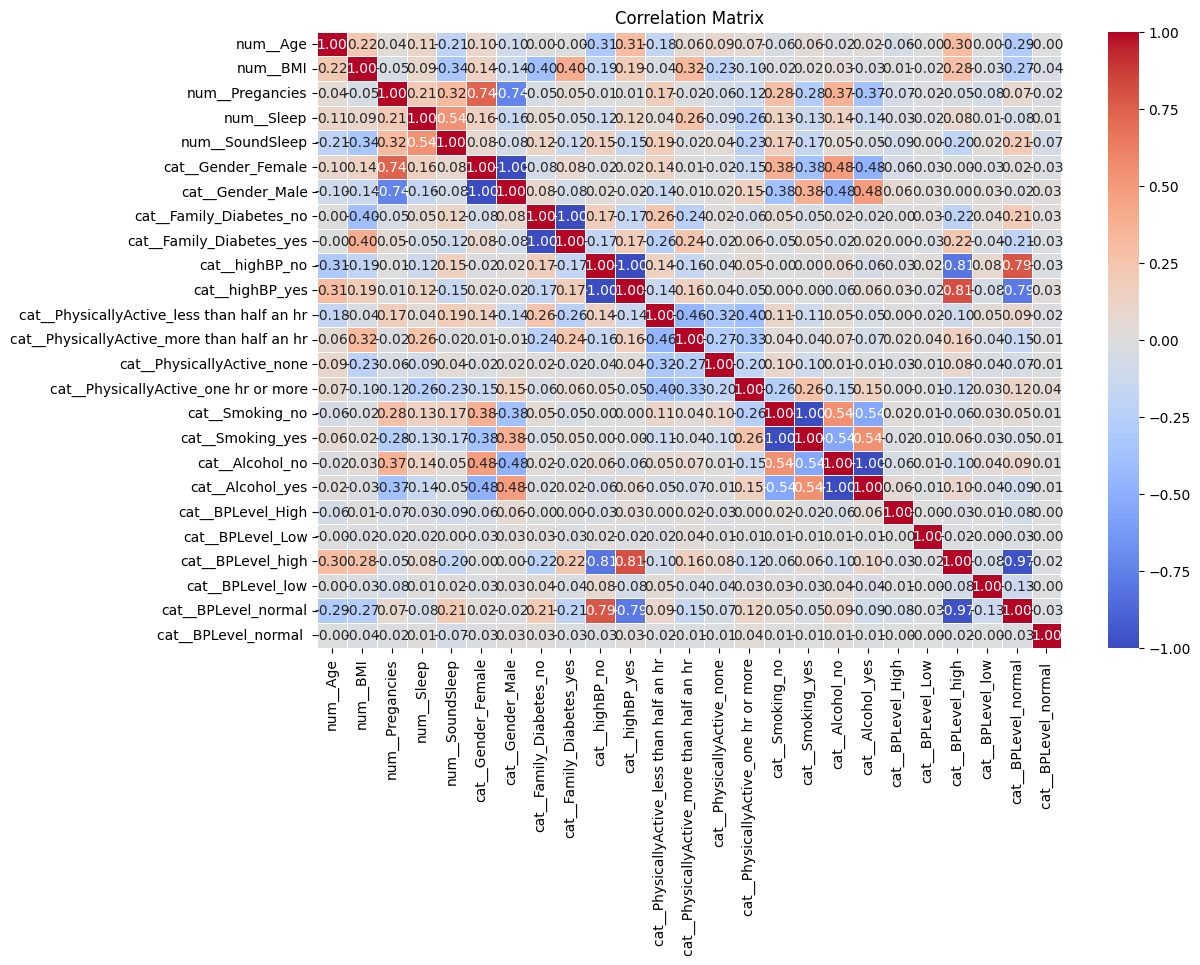

                                            num__Age  num__BMI  \
num__Age                                    1.000000  0.219837   
num__BMI                                    0.219837  1.000000   
num__Pregancies                             0.044100 -0.048025   
num__Sleep                                  0.114375  0.087582   
num__SoundSleep                            -0.207868 -0.336068   
cat__Gender_Female                          0.098432  0.140126   
cat__Gender_Male                           -0.098432 -0.140126   
cat__Family_Diabetes_no                     0.002335 -0.395597   
cat__Family_Diabetes_yes                   -0.002335  0.395597   
cat__highBP_no                             -0.311055 -0.191386   
cat__highBP_yes                             0.311055  0.191386   
cat__PhysicallyActive_less than half an hr -0.175124 -0.039955   
cat__PhysicallyActive_more than half an hr  0.059198  0.318114   
cat__PhysicallyActive_none                  0.087131 -0.232221   
cat__Physi

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train_smote_df = pd.DataFrame(X_train_smote, columns=preprocessor.get_feature_names_out())

# Generate the correlation matrix
corr_matrix = X_train_smote_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

print(corr_matrix)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model to evaluate feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_smote_df.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importance_df)


                                       Feature  Importance
2                              num__Pregancies    0.205519
1                                     num__BMI    0.095190
4                              num__SoundSleep    0.081070
3                                   num__Sleep    0.071806
6                             cat__Gender_Male    0.058135
0                                     num__Age    0.053376
5                           cat__Gender_Female    0.052271
8                     cat__Family_Diabetes_yes    0.044955
11  cat__PhysicallyActive_less than half an hr    0.044192
13                  cat__PhysicallyActive_none    0.038670
7                      cat__Family_Diabetes_no    0.037938
21                           cat__BPLevel_high    0.037674
9                               cat__highBP_no    0.034218
10                             cat__highBP_yes    0.032206
23                         cat__BPLevel_normal    0.027395
12  cat__PhysicallyActive_more than half an hr    0.0272

In [ ]:
# Keep the top 15 most important features
top_n = 15
top_features = feature_importance_df.head(top_n)['Feature']

# Filter the dataset to keep only the top features
X_train_top_features = X_train_smote_df[top_features]
X_test_top_features = X_test_processed[:, :len(top_features)]  # Ensure the test set matches the selected features

''' Top Features '''
'''
num__Pregancies (0.205519)
num__BMI (0.095190)
num__SoundSleep (0.081070)
num__Sleep (0.071806)
cat__Gender_Male (0.058135)
num__Age (0.053376)
cat__Gender_Female (0.052271)
cat__Family_Diabetes_yes (0.044955)
cat__PhysicallyActive_less than half an hr (0.044192)
cat__PhysicallyActive_none (0.038670)
cat__Family_Diabetes_no (0.037938)
cat__BPLevel_high (0.037674)
cat__highBP_no (0.034218)
cat__highBP_yes (0.032206)
cat__BPLevel_normal (0.027395)

'''


Fine Tune Trained Model on New Dataset

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Load the fine-tuned model
fine_tuned_model = load_model('fine_tuned_model_with_modified_input.h5')

# Number of classes (No Diabetes, Prediabetes, Type-2 Diabetes, Gestational Diabetes)
num_classes = 4

# Build a new model for fine-tuning with multi-class output
model = Sequential()

# Modify the input layer to accept only 15 features
model.add(Dense(128, input_shape=(15,), activation='relu'))
model.add(Dropout(0.2))

# Manually add the remaining layers from the pre-trained model with unique names
for i, layer in enumerate(fine_tuned_model.layers[1:-1]):  # Exclude the last layer
    if isinstance(layer, BatchNormalization):  # Handle BatchNormalization
        model.add(BatchNormalization(name=f"{layer.name}_{i}"))
    elif isinstance(layer, Dropout):  # Handle Dropout
        model.add(Dropout(rate=layer.rate, name=f"{layer.name}_{i}"))
    elif isinstance(layer, LeakyReLU):  # Handle LeakyReLU activation layer without passing alpha
        model.add(LeakyReLU(name=f"{layer.name}_{i}"))
    elif isinstance(layer, Dense):  # Handle Dense layers
        model.add(Dense(units=layer.units, activation=layer.activation, name=f"{layer.name}_{i}"))

# Add a new output layer for multi-class classification (4 classes)
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class output

# Compile the model with sparse categorical crossentropy loss (for label-encoded targets)
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_0                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18_3             │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18_4 (LeakyReLU)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12_5 (Dropout)               │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25_6 (Dense)                   │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19_7             │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19_8 (LeakyReLU)         │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13_9 (Dropout)               │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26_10 (Dense)                  │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20_11            │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20_12 (LeakyReLU)        │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,924 (54.39 KB)

 Trainable params: 13,220 (51.64 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
print(X_train_top_features.dtypes)  # Check if all columns are numerical

print(X_train_top_features.shape)  # Should be (num_samples, 15)
print(X_test_top_features.shape)   # Should be (num_samples, 15)

import numpy as np

# Ensure the features and labels are NumPy arrays
X_train_top_features = np.array(X_train_top_features)
X_test_top_features = np.array(X_test_top_features)
y_train_smote = np.array(y_train_smote)
y_test = np.array(y_test)



num__Pregancies                               float64
num__BMI                                      float64
num__SoundSleep                               float64
num__Sleep                                    float64
cat__Gender_Male                              float64
num__Age                                      float64
cat__Gender_Female                            float64
cat__Family_Diabetes_yes                      float64
cat__PhysicallyActive_less than half an hr    float64
cat__PhysicallyActive_none                    float64
cat__Family_Diabetes_no                       float64
cat__BPLevel_high                             float64
cat__highBP_no                                float64
cat__highBP_yes                               float64
cat__BPLevel_normal                           float64
dtype: object
(2192, 15)
(190, 15)


In [ ]:
print(y_train_smote.shape)  # Should be (num_samples,)
print(y_test.shape)         # Should be (num_samples,)


(2192,)
(190,)


In [ ]:
print(X_train_top_features.shape)  # Expected shape: (num_samples, 15)
print(X_test_top_features.shape)   # Expected shape: (num_samples, 15)
print(y_train_smote.shape)         # Expected shape: (num_samples,)
print(y_test.shape)                # Expected shape: (num_samples,)

# Reshape labels to 1D if needed
y_train_smote = y_train_smote.reshape(-1)
y_test = y_test.reshape(-1)

# Check the model's output layer
model.summary()  # Ensure the output layer has 4 units and uses softmax

(2192, 15)
(190, 15)
(2192,)
(190,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_0                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18_3             │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18_4 (LeakyReLU)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12_5 (Dropout)               │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25_6 (Dense)                   │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19_7             │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19_8 (LeakyReLU)         │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13_9 (Dropout)               │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26_10 (Dense)                  │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20_11            │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20_12 (LeakyReLU)        │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,366 (157.68 KB)

 Trainable params: 13,220 (51.64 KB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 26,442 (103.29 KB)

In [ ]:
print(np.unique(y_train_smote))  # Check unique values in y_train_smote
print(np.unique(y_test))         # Check unique values in y_test


[0 1 2 3]
['Gestational Diabetes' 'No Diabetes' 'Prediabetes' 'Type-2 Diabetes']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit on the training labels to ensure consistent encoding
label_encoder.fit(['No Diabetes', 'Prediabetes', 'Type-2 Diabetes', 'Gestational Diabetes'])

# Transform the test labels
y_test_encoded = label_encoder.transform(y_test)

# Train the model on the label-encoded target variable
# Train the model
history = model.fit(X_train_top_features, y_train_smote,
                    validation_data=(X_test_top_features, y_test_encoded),
                    epochs=30, batch_size=32)


# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_top_features, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the fine-tuned model
model.save('fine_tuned_model_on_new_dataset.h5')

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8574 - loss: 0.3908 - val_accuracy: 0.2053 - val_loss: nan
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8572 - loss: 0.3836 - val_accuracy: 0.2053 - val_loss: nan
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.3449 - val_accuracy: 0.2105 - val_loss: nan
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.3586 - val_accuracy: 0.2053 - val_loss: nan
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8508 - loss: 0.3826 - val_accuracy: 0.2053 - val_loss: nan
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8684 - loss: 0.3619 - val_accuracy: 0.2053 - val_loss: nan
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - loss: 0.3712 - val_accuracy: 0.2053 - val_loss: nan
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8631 - loss: 0.3665 - val_accuracy: 0.2053 - val_loss: nan
Epoch 9/30
69/69

Test Accuracy: 21.58%


Model trained on CGM dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib


# Load the dataset
df = pd.read_csv('merged_CGM_clinical_data.csv')

# Preprocess the data
df['Hora'] = pd.to_timedelta(df['Hora']).dt.total_seconds()
df = df.dropna()

numerical_cols = ['Hora', 'Glucemia', 'BMI', 'age', 'HbA1c', 'follow.up']

# Scale the numerical columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# saving scaler for time series data in Streamlit app
joblib.dump(scaler, 'time_series_scaler.pkl')

# Handle class imbalance by oversampling the minority class
from sklearn.utils import resample

# Check class distribution
df_majority = df[df.T2DM == False]
df_minority = df[df.T2DM == True]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority and upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Prepare the features and target
X_data = df_upsampled[numerical_cols].values
y_data = df_upsampled['T2DM'].astype(int).values

# Set the number of timesteps (window size)
window_size = 10  # Adjust this to the number of timesteps you want

# Define a function to create sequences of data (sliding window approach)
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])  # Predict the value after the window
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(X_data, y_data, window_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model with regularization and dropout
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Define input shape with multiple timesteps
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting
model.add(LSTM(64, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(25, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Plot the accuracy and loss curves
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No T2DM', 'T2DM'], yticklabels=['No T2DM', 'T2DM'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




'\n# Handle class imbalance by oversampling the minority class\nfrom sklearn.utils import resample\n\n# Check class distribution\ndf_majority = df[df.T2DM == False]\ndf_minority = df[df.T2DM == True]\n\n# Upsample minority class\ndf_minority_upsampled = resample(df_minority,\n                                 replace=True,     # sample with replacement\n                                 n_samples=len(df_majority),    # to match majority class\n                                 random_state=42)  # reproducible results\n\n# Combine majority and upsampled minority class\ndf_upsampled = pd.concat([df_majority, df_minority_upsampled])\n\n# Prepare the features and target\nX_data = df_upsampled[numerical_cols].values\ny_data = df_upsampled[\'T2DM\'].astype(int).values\n\n# Set the number of timesteps (window size)\nwindow_size = 10  # Adjust this to the number of timesteps you want\n\n# Define a function to create sequences of data (sliding window approach)\ndef create_sequences(data, target, w

In [ ]:
model.save('/content/time_series_model.h5')

Combining trained Dense Model and Time Series Model

In [ ]:
from tensorflow import keras

# Load the two models
model_1_path = '/content/time_series_model.h5'
model_2_path = '/content/fine_tuned_model_on_new_dataset.h5'

# Load models
model_1 = keras.models.load_model(model_1_path)
model_2 = keras.models.load_model(model_2_path)

# Summarize the models to analyze their architectures
model_1.summary()
model_2.summary()

model_2.input_shape


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                       │ (None, 10, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_53 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,853 (206.46 KB)

 Trainable params: 52,851 (206.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_0                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18_3             │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18_4 (LeakyReLU)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12_5 (Dropout)               │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25_6 (Dense)                   │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19_7             │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19_8 (LeakyReLU)         │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13_9 (Dropout)               │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26_10 (Dense)                  │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20_11            │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20_12 (LeakyReLU)        │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,926 (54.40 KB)

 Trainable params: 13,220 (51.64 KB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)

(None, 15)

In [ ]:
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model

# Define input shapes based on the original models
time_series_input_shape = model_1.input_shape[1:]  # Exclude batch size
fine_tuned_input_shape = model_2.input_shape[1:]   # Exclude batch size

# Create new input layers for both models
time_series_input = Input(shape=time_series_input_shape)
fine_tuned_input = Input(shape=fine_tuned_input_shape)

# Call each model on its respective input
time_series_output = model_1(time_series_input)
fine_tuned_output = model_2(fine_tuned_input)

# Concatenate the outputs from the two models
combined_features = concatenate([time_series_output, fine_tuned_output])

# Add a new output layer for the combined model
new_output = Dense(4, activation='softmax')(combined_features)  # 4 classes

# Create the new combined model
combined_model = Model(inputs=[time_series_input, fine_tuned_input], outputs=new_output)

# Compile the model (use suitable optimizer and loss for multiclass classification)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the new combined model
combined_model.summary()

combined_model.save('/content/final_deep_learning_model.h5')



Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 10, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_44             │ (None, 1)              │         52,851 │ input_layer_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 4)              │         13,924 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 5)              │              0 │ sequential_44[1][0],   │
│ (Concatenate)             │                        │                │ sequential_6[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │             24 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 66,799 (260.93 KB)

 Trainable params: 66,095 (258.18 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
from tensorflow.keras.models import load_model

# Load the combined model
combined_model = load_model('final_deep_learning_model.h5')

# Get the input shapes of the combined model
time_series_input_shape = combined_model.input[0].shape
fine_tuned_input_shape = combined_model.input[1].shape

print(f"Time Series Input Shape: {time_series_input_shape}")
print(f"Fine-Tuned Input Shape: {fine_tuned_input_shape}")

Time Series Input Shape: (None, 10, 6)
Fine-Tuned Input Shape: (None, 15)


In [1]:

import pandas as pd

# Load the dataset
time_series_data = pd.read_csv('/content/merged_CGM_clinical_data.csv')

# Display the first few rows to check the structure
print(time_series_data.head())


   Patient_ID      Hora  Glucemia  gender  age   BMI  glycaemia  HbA1c  \
0           1  00:00:00      87.0       1   77  25.4        106    6.3   
1           1  00:00:03      95.0       1   77  25.4        106    6.3   
2           1  00:00:05     104.0       1   77  25.4        106    6.3   
3           1  00:00:06     159.0       1   77  25.4        106    6.3   
4           1  00:00:07     114.0       1   77  25.4        106    6.3   

   follow.up   T2DM  
0      413.0  False  
1      413.0  False  
2      413.0  False  
3      413.0  False  
4      413.0  False  
